# ***Player Profile and Market Value:Linear Regression***

Importing necessary python libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#load the data file
football_data = pd.read_csv("/content/Football_data_merged_cleaned_data (3).csv")
football_data.head()

,appearance_id,game_id_x,player_id_x,competition_id_x,yellow_cards,red_cards,goals,assists,minutes_played,season,...,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,game_lineups_id,type_y,number,player_name_y,team_captain,position_y
0,2231426_49723,2231426,49723,L1,0,0,0,0,70,2012,...,186.0,700000.0,5000000.0,2025-06-30 00:00:00.000000000,8d717b1017e72d89d2ee1112bb2d7466,substitutes,22,Timothy Chandler,0,Right-Back
1,2231426_49723,2231426,49723,L1,0,0,0,0,70,2012,...,186.0,700000.0,5000000.0,2025-06-30 00:00:00.000000000,d53eb3fd74523d6dd4536653c145ae96,substitutes,22,Timothy Chandler,0,Right-Back
2,2231426_49723,2231426,49723,L1,0,0,0,0,70,2012,...,186.0,700000.0,5000000.0,2025-06-30 00:00:00.000000000,3efc21c645e46b2f411bcdb1710aa444,substitutes,22,Timothy Chandler,0,Right-Back
3,2231426_49723,2231426,49723,L1,0,0,0,0,70,2012,...,186.0,700000.0,5000000.0,2025-06-30 00:00:00.000000000,cc79e78c570ce19872dfed125d324407,substitutes,22,Timothy Chandler,0,Right-Back
4,2231426_49723,2231426,49723,L1,0,0,0,0,70,2012,...,186.0,700000.0,5000000.0,2025-06-30 00:00:00.000000000,21de58902f547e231bf2604be9fa996f,substitutes,22,Timothy Chandler,0,Right-Back


**Simple Linear Regression**

In [ ]:
#Influencing factors of maket_value_in_eur
df = football_data[["minutes_played","height_in_cm","highest_market_value_in_eur","assists","goals","market_value_in_eur"]]
df

,minutes_played,height_in_cm,highest_market_value_in_eur,assists,goals,market_value_in_eur
0,70,186.0,5000000.0,0,0,700000.0
1,70,186.0,5000000.0,0,0,700000.0
2,70,186.0,5000000.0,0,0,700000.0
3,70,186.0,5000000.0,0,0,700000.0
4,70,186.0,5000000.0,0,0,700000.0
...,...,...,...,...,...,...
4194,77,176.0,600000.0,0,1,300000.0
4195,77,176.0,600000.0,0,1,300000.0
4196,77,176.0,600000.0,0,1,300000.0
4197,77,176.0,600000.0,0,1,300000.0


In [ ]:
#Check correlation
sorted_corr=df.corr()[['market_value_in_eur']].sort_values(by="market_value_in_eur",ascending=False)
sorted_corr

,market_value_in_eur
market_value_in_eur,1.000000
highest_market_value_in_eur,0.941945
assists,0.173245
goals,0.091787
minutes_played,0.077168
height_in_cm,-0.345867


**Interpretation:**Here highest_market_value highly correlated with market_value..so we take highest_market_value for regression....

In [ ]:
df_linear=df[["highest_market_value_in_eur","market_value_in_eur"]]
df_linear

,highest_market_value_in_eur,market_value_in_eur
0,5000000.0,700000.0
1,5000000.0,700000.0
2,5000000.0,700000.0
3,5000000.0,700000.0
4,5000000.0,700000.0
...,...,...
4194,600000.0,300000.0
4195,600000.0,300000.0
4196,600000.0,300000.0
4197,600000.0,300000.0


*Winsorization Tecnique:*

In [ ]:
def iqr_winsorization(df, thresh=1.5, columns_to_treat=['market_value_in_eur', 'highest_market_value_in_eur']):
  """
  This function treats outliers in a DataFrame using IQR and winsorization.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.
      thresh (float, optional): The multiplier for IQR to define outlier thresholds. Defaults to 1.5.
      columns_to_treat (list, optional): A list of column names to treat for outliers. Defaults to ['market_value_eur', 'highest_market_value_eur'].

  Returns:
      pandas.DataFrame: The DataFrame with outliers winsorized.
  """
  df_out = df.copy()  # Create a copy to avoid modifying original data

  # Check if 'columns_to_treat' are numerical
  for col in columns_to_treat:
    if not pd.api.types.is_numeric_dtype(df_out[col]):
      raise ValueError(f"Column '{col}' is not numerical. IQR winsorization only applies to numerical columns.")

  for col in columns_to_treat:
    # Calculate IQR only for numerical columns
    Q1 = df_out[col].quantile(0.25)
    Q3 = df_out[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define fences
    lower_fence = Q1 - thresh * IQR
    upper_fence = Q3 + thresh * IQR

    # Winsorize outliers
    df_out.loc[df_out[col] < lower_fence, col] = lower_fence
    df_out.loc[df_out[col] > upper_fence, col] = upper_fence

  return df_out

# Assuming you have your DataFrame 'df'
weather_winsorized_df = iqr_winsorization(df.copy())

# Print original and winsorized DataFrames
print("Original DataFrame:")
print(df)
print("\nDataFrame after outlier treatment for market_value_eur and highest_market_value_eur:")
print(weather_winsorized_df)


Original DataFrame:
      minutes_played  height_in_cm  highest_market_value_in_eur  assists  \
0                 70         186.0                    5000000.0        0   
1                 70         186.0                    5000000.0        0   
2                 70         186.0                    5000000.0        0   
3                 70         186.0                    5000000.0        0   
4                 70         186.0                    5000000.0        0   
...              ...           ...                          ...      ...   
4194              77         176.0                     600000.0        0   
4195              77         176.0                     600000.0        0   
4196              77         176.0                     600000.0        0   
4197              77         176.0                     600000.0        0   
4198              77         176.0                     600000.0        0   

      goals  market_value_in_eur  
0         0             700000.0

### ***Data Scaling***

In [ ]:
cols = df_linear.columns
scaler = StandardScaler()
df_linear_scaled = scaler.fit_transform(df_linear)
df_scaled=pd.DataFrame(df_linear_scaled, columns=cols)
df_scaled.head()

,highest_market_value_in_eur,market_value_in_eur
0,-0.82468,-0.977711
1,-0.82468,-0.977711
2,-0.82468,-0.977711
3,-0.82468,-0.977711
4,-0.82468,-0.977711


## ***Deriving Target variable,Independent Variable and Data Splitting***

In [ ]:
x=df_scaled[['highest_market_value_in_eur']]
y=df_scaled[['market_value_in_eur']]
X_gr=np.array(df_scaled['highest_market_value_in_eur']).reshape((-1, 1))
y=np.array(df_scaled['market_value_in_eur'])

X_train_gr,X_test_gr,y_train,y_test =train_test_split(X_gr,y,test_size=0.3,random_state=20)
s_model=LinearRegression().fit(X_train_gr,y_train)
s_r_sq=s_model.score(X_train_gr, y_train)
print(s_r_sq)
print('intercept:', s_model.intercept_)
print('slope:', s_model.coef_)

0.8859849476069753
intercept: 0.0027217697035260132
slope: [0.94168289]


***Predict value***

In [ ]:
y_pred = s_model.predict(X_test_gr)
print('predicted response:', y_pred, sep='\n')

predicted response:
[-0.58090981 -0.8510474  -0.9398069  ...  1.34864446 -0.38795438
 -0.00204353]


***Linear Regression Evalution metrics***

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MAE=mean_absolute_error(y_test,y_pred)
RMSE = mean_squared_error(y_test, y_pred)
print('MSE:',MSE)
print('MAE:',MAE)
print('RMSE:',RMSE)
# R2 Score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"The R2 score of the model is", r2)

MSE: 0.11050483055919728
MAE: 0.23279453765824246
RMSE: 0.11050483055919728
The R2 score of the model is 0.8901747542448888


**Interpretation:**MSE: The model's average squared error is relatively low, suggesting that the predictions are fairly accurate.
MAE: The average absolute error is also relatively low, indicating that the model's predictions are generally close to the actual values.
RMSE: The root mean squared error provides a measure of the standard deviation of the residuals. A lower RMSE indicates better model performance.
R-squared: The R-squared value of 0.89 indicates that 89% of the variance in the dependent variable is explained by the independent variable(s). This is a strong indication of a good model fit.

### ***Checking for Linear Relationship***

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    return df_results

def linear_assumption(model, features, label):
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')

    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')

    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)

    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')

    plt.title('Actual vs. Predicted')

    plt.show()


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


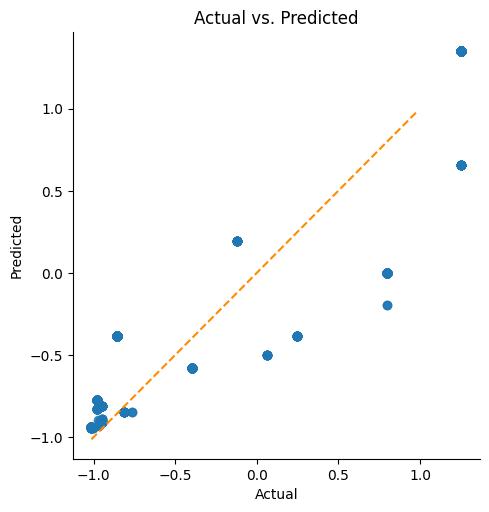

In [ ]:
linear_assumption(s_model, X_test_gr, y_test)

###  Checking Homoscedasticity: Plot the residuals of linear regression

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption: Homoscedasticity of Error Terms', '\n')

    print('Residuals should have relative constant variance')

    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    #print(df_results)
    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residual plot')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

Assumption: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


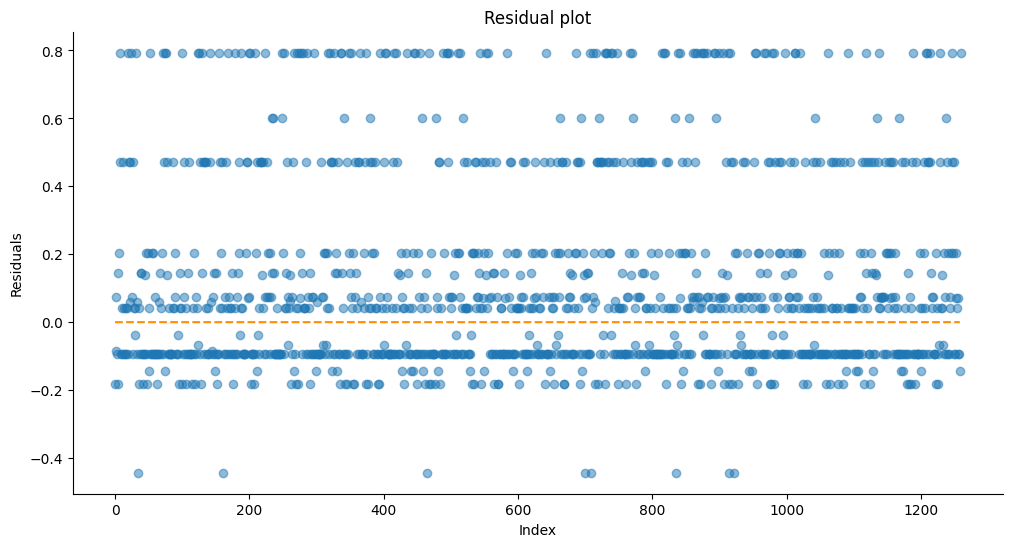

In [ ]:
homoscedasticity_assumption(s_model, X_test_gr, y_test)

### Error Normality curve

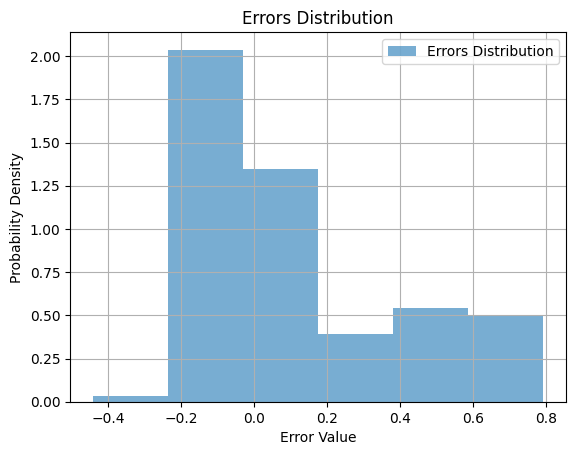

In [ ]:
df_results = calculate_residuals(s_model, X_test_gr, y_test)
plt.hist(df_results.Residuals, density=True, bins=6, alpha=0.6, label='Errors Distribution')  # Plot errors histogram
plt.xlabel('Error Value')
plt.ylabel('Probability Density')
plt.title('Errors Distribution')
plt.legend()
plt.grid(True)
plt.show()

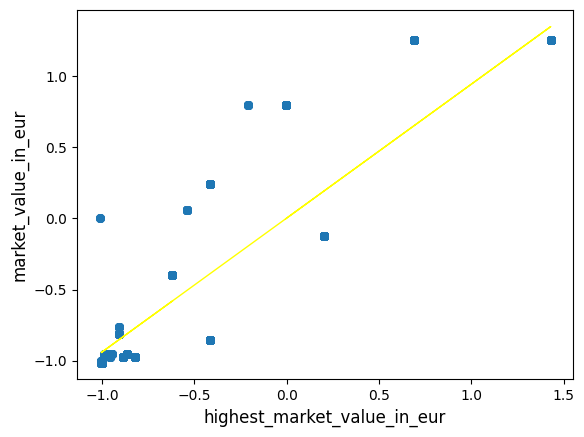

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('xlabel', fontsize=12)
ax.set_ylabel('ylabel', fontsize=12)
#plt.ylim((0,4))
#weather_df_test=X_test

df_scaled.plot.scatter(x = 'highest_market_value_in_eur', y = 'market_value_in_eur', s = 30, ax=ax)
plt.plot(X_test_gr, y_pred, color="yellow", linewidth=1)
plt.show()


## **Multiple Linear Regression**

In [ ]:
df_multiple = football_data[["minutes_played","height_in_cm","highest_market_value_in_eur","goals","market_value_in_eur"]]
df_multiple

,minutes_played,height_in_cm,highest_market_value_in_eur,goals,market_value_in_eur
0,70,186.0,5000000.0,0,700000.0
1,70,186.0,5000000.0,0,700000.0
2,70,186.0,5000000.0,0,700000.0
3,70,186.0,5000000.0,0,700000.0
4,70,186.0,5000000.0,0,700000.0
...,...,...,...,...,...
4194,77,176.0,600000.0,1,300000.0
4195,77,176.0,600000.0,1,300000.0
4196,77,176.0,600000.0,1,300000.0
4197,77,176.0,600000.0,1,300000.0


([0, 1, 2, 3, 4],
 [Text(0, 0, 'minutes_played'),
  Text(1, 0, 'height_in_cm'),
  Text(2, 0, 'highest_market_value_in_eur'),
  Text(3, 0, 'goals'),
  Text(4, 0, 'market_value_in_eur')])

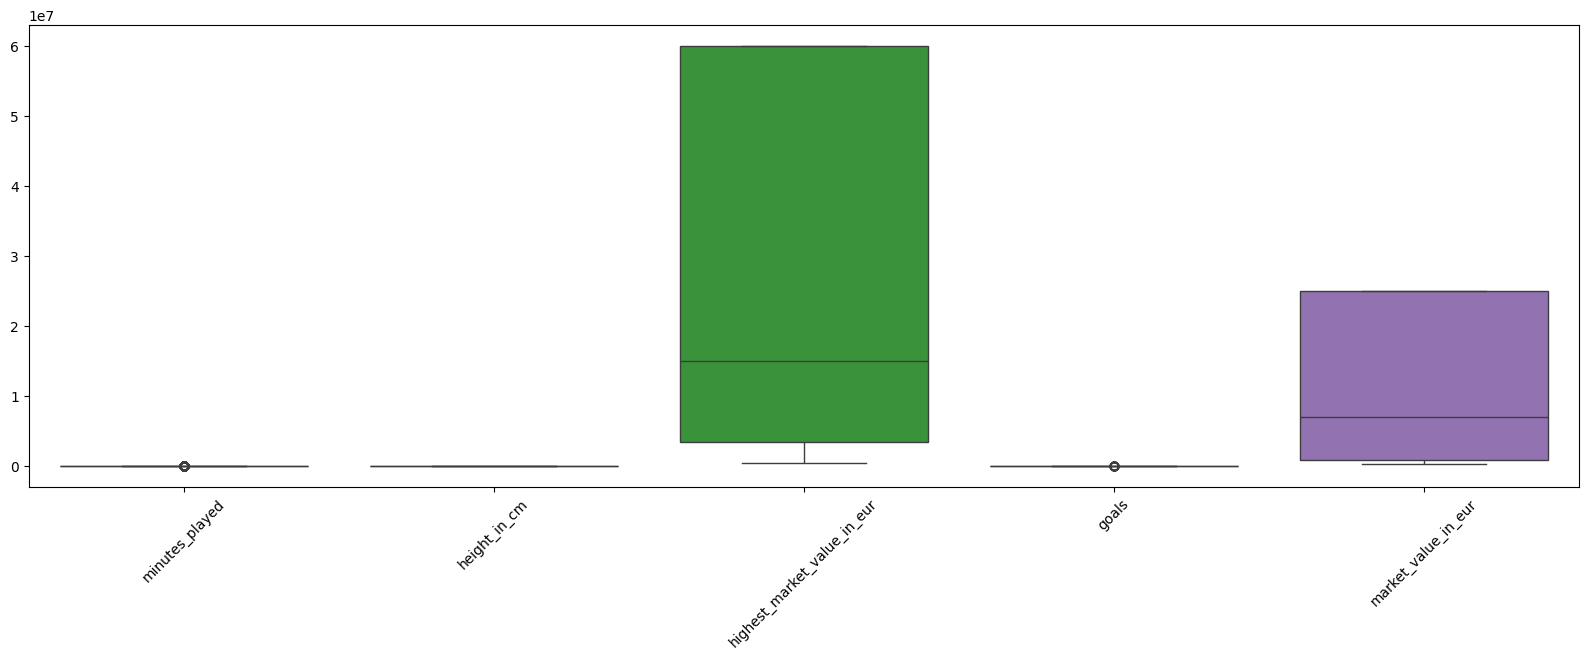

In [ ]:
sns.boxplot(data=df_multiple)
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation=45)

In [ ]:
def iqr_winsorization(df, thresh=1.5):
    df_out = df.copy()  # Create a copy to avoid modifying original data
    columns_to_treat=df_out.columns
    for col in columns_to_treat:
        # Calculate IQR
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define fences
        lower_fence = Q1 - thresh * IQR
        upper_fence = Q3 + thresh * IQR

        # Winsorize outliers
        df_out.loc[df_out[col] < lower_fence, col] = lower_fence
        df_out.loc[df_out[col] > upper_fence, col] = upper_fence

    return df_out

df = pd.DataFrame(df_multiple)
# Perform outlier treatment on all columns
treated_multiple_df = iqr_winsorization(df.copy())
print(treated_multiple_df )

      minutes_played  height_in_cm  highest_market_value_in_eur  goals  \
0               70.0         186.0                    5000000.0    0.0   
1               70.0         186.0                    5000000.0    0.0   
2               70.0         186.0                    5000000.0    0.0   
3               70.0         186.0                    5000000.0    0.0   
4               70.0         186.0                    5000000.0    0.0   
...              ...           ...                          ...    ...   
4194            77.0         176.0                     600000.0    1.0   
4195            77.0         176.0                     600000.0    1.0   
4196            77.0         176.0                     600000.0    1.0   
4197            77.0         176.0                     600000.0    1.0   
4198            77.0         176.0                     600000.0    1.0   

      market_value_in_eur  
0                700000.0  
1                700000.0  
2                700000.0  

([0, 1, 2, 3, 4],
 [Text(0, 0, 'minutes_played'),
  Text(1, 0, 'height_in_cm'),
  Text(2, 0, 'highest_market_value_in_eur'),
  Text(3, 0, 'goals'),
  Text(4, 0, 'market_value_in_eur')])

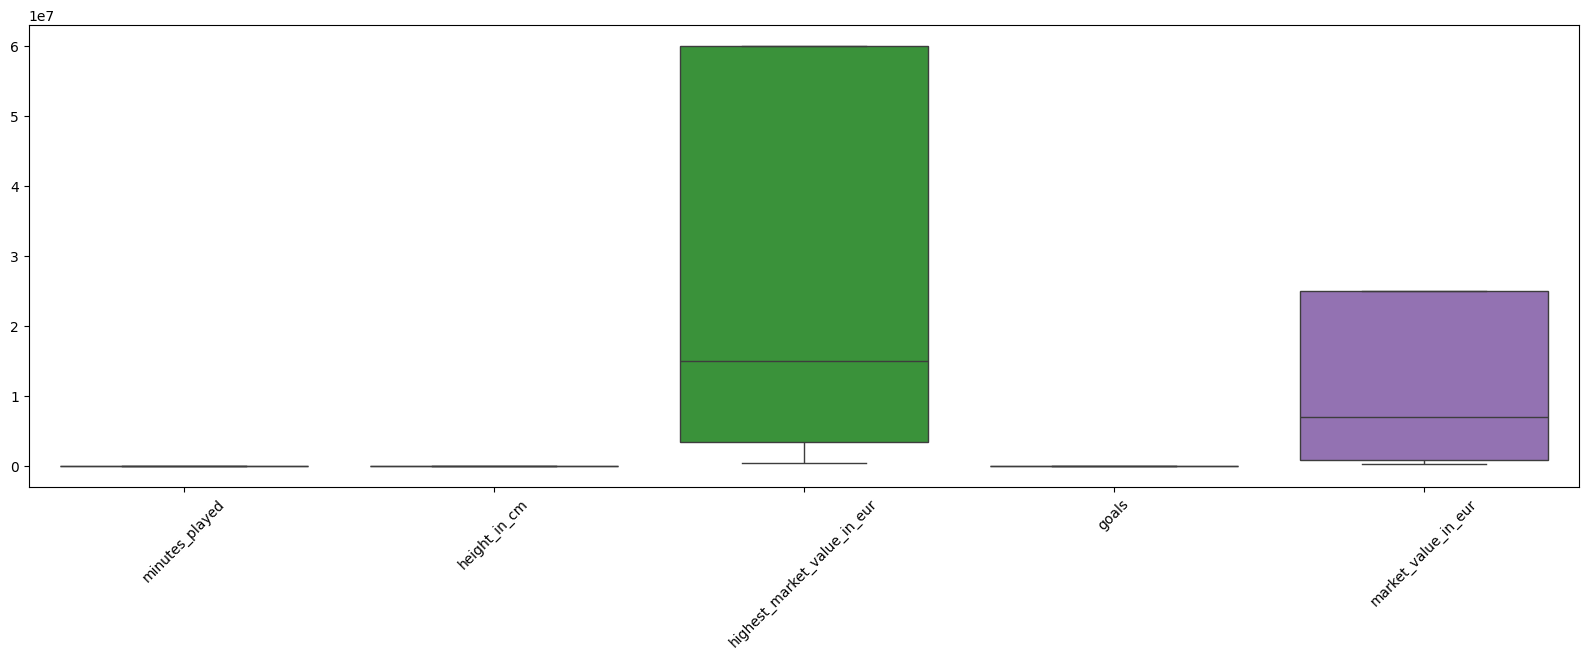

In [ ]:
sns.boxplot(data=treated_multiple_df)
plt.gcf().set_size_inches(20, 6)
plt.xticks(rotation=45)

In [ ]:
sorted_corr2=df.corr()[['market_value_in_eur']].sort_values(by="market_value_in_eur",ascending=False)
sorted_corr2

,market_value_in_eur
market_value_in_eur,1.000000
highest_market_value_in_eur,0.941945
goals,0.091787
minutes_played,0.077168
height_in_cm,-0.345867


In [ ]:
cols = treated_multiple_df.columns
scaler = StandardScaler()
df_multiple_scaled = scaler.fit_transform(treated_multiple_df)
df_multiple_scaled=pd.DataFrame(df_multiple_scaled, columns=cols)
df_multiple_scaled.head()

,minutes_played,height_in_cm,highest_market_value_in_eur,goals,market_value_in_eur
0,0.004798,0.650517,-0.82468,-0.733861,-0.977711
1,0.004798,0.650517,-0.82468,-0.733861,-0.977711
2,0.004798,0.650517,-0.82468,-0.733861,-0.977711
3,0.004798,0.650517,-0.82468,-0.733861,-0.977711
4,0.004798,0.650517,-0.82468,-0.733861,-0.977711


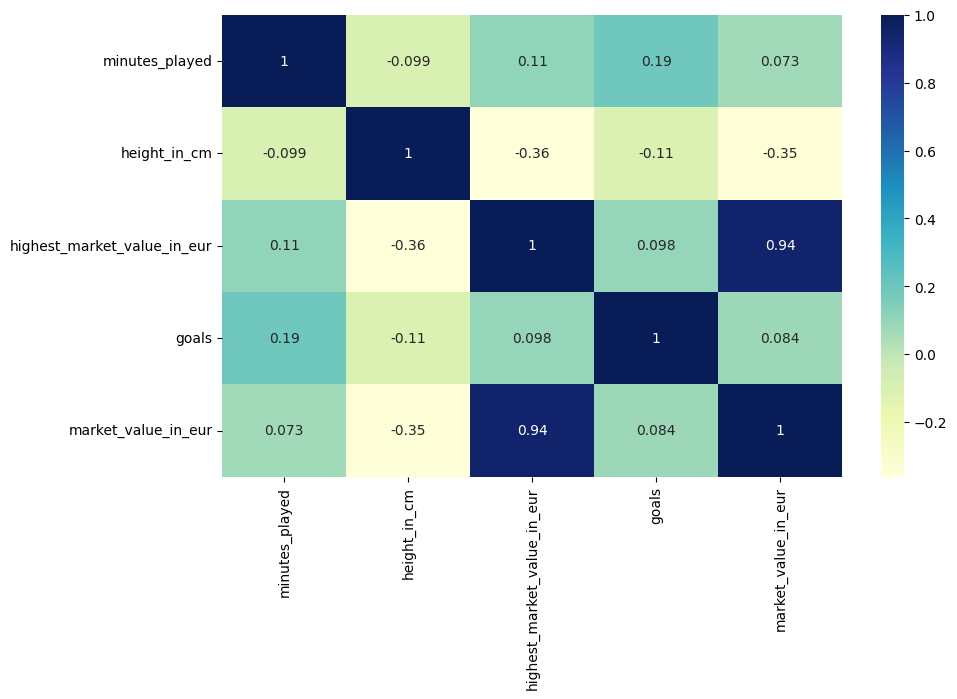

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax=sns.heatmap(df_multiple_scaled.corr(),annot=True,cmap="YlGnBu")

In [ ]:
# To show the correlation values from most negatively correlated to the most positively correlated.
sorted_corr=df_multiple_scaled.corr()[['market_value_in_eur']].sort_values(by='market_value_in_eur', ascending=False)
sorted_corr

,market_value_in_eur
market_value_in_eur,1.000000
highest_market_value_in_eur,0.941945
goals,0.084043
minutes_played,0.073334
height_in_cm,-0.345867


**1.Feature:Highest_market_value_in_eur**

In [ ]:
x1 = df_multiple_scaled['highest_market_value_in_eur']
y = df_multiple_scaled['market_value_in_eur']

x1_train,x1_test,y1_train,y1_test =train_test_split(x1,y,test_size=0.3,random_state=20)
# Reshape x1_train and x1_test to 2D arrays
x1_train = x1_train.values.reshape(-1, 1)
x1_test = x1_test.values.reshape(-1, 1)
s_model1 = LinearRegression().fit(x1_train,y1_train)
s_r_sq=s_model.score(x1_train, y1_train)
print(s_r_sq)
print('intercept:', s_model.intercept_)
print('slope:', s_model.coef_)

0.8859849476069753
intercept: 0.0027217697035260132
slope: [0.94168289]


In [ ]:
y1_pred=s_model1.predict(x1_test)
print("Predicted response:",y1_pred,sep='\n')

Predicted response:
[-0.58090981 -0.8510474  -0.9398069  ...  1.34864446 -0.38795438
 -0.00204353]


In [ ]:
MSE1=mean_squared_error(y1_test, y1_pred)
MAE1=mean_absolute_error(y1_test,y1_pred)
RMSE1 = mean_squared_error(y1_test, y1_pred)
print('MSE1:',MSE1)
print('MAE1:',MAE1)
print('RMSE1:',RMSE1)
# R2 Score
from sklearn.metrics import r2_score
r2_1 = r2_score(y1_test, y1_pred)
print(f"The R2_1 score of the model is", r2_1)

MSE1: 0.11050483055919728
MAE1: 0.23279453765824246
RMSE1: 0.11050483055919728
The R2_1 score of the model is 0.8901747542448888


2 Features(highest_market_value_in_eur,goals)

*   List item
*   List item



In [ ]:
x2 = df_multiple_scaled[['highest_market_value_in_eur','goals']]
y = df_multiple_scaled['market_value_in_eur']

x2_train,x2_test,y2_train,y2_test =train_test_split(x2,y,test_size=0.3,random_state=20)
# Reshape x1_train and x1_test to 2D arrays

s_model2 = LinearRegression().fit(x2_train,y2_train)
s_r_sq2=s_model2.score(x2_train, y2_train)
print(s_r_sq)
print('intercept:', s_model2.intercept_)
print('slope:', s_model2.coef_)

0.8859849476069753
intercept: 0.0027297950401551432
slope: [ 0.94251432 -0.0092291 ]


In [ ]:
y2_pred=s_model2.predict(x2_test)
print("Predicted response:",y2_pred,sep='\n')

Predicted response:
[-0.5746442  -0.84502031 -0.93385817 ...  1.3405463  -0.39758582
  0.00473317]


In [ ]:
MSE2=mean_squared_error(y2_test, y2_pred)
MAE2=mean_absolute_error(y2_test,y2_pred)
RMSE2 = mean_squared_error(y2_test, y2_pred)
print('MSE2:',MSE2)
print('MAE2:',MAE2)
print('RMSE2:',RMSE2)
# R2 Score
from sklearn.metrics import r2_score
r2_2 = r2_score(y2_test, y2_pred)
print(f"The R2_2 score of the model is", r2_2)

MSE2: 0.11047747893260519
MAE2: 0.23276118808157048
RMSE2: 0.11047747893260519
The R2_2 score of the model is 0.8902019376639039


3 Features(highest_market_value_in_eur,goals,minutes_played)


In [ ]:
x3 = df_multiple_scaled[['highest_market_value_in_eur','goals','minutes_played']]
y = df_multiple_scaled['market_value_in_eur']

x3_train,x3_test,y3_train,y3_test =train_test_split(x3,y,test_size=0.3,random_state=20)
# Reshape x1_train and x1_test to 2D arrays

s_model3 = LinearRegression().fit(x3_train,y3_train)
s_r_sq3=s_model3.score(x3_train, y3_train)
print(s_r_sq)
print('intercept:', s_model3.intercept_)
print('slope:', s_model3.coef_)

0.8859849476069753
intercept: 0.002958771197400605
slope: [ 0.94542198 -0.0032784  -0.03152733]


In [ ]:
y3_pred=s_model3.predict(x3_test)
print("Predicted response:",y3_pred,sep='\n')

Predicted response:
[-0.58498378 -0.83495289 -0.85963345 ...  1.32245127 -0.42104299
 -0.02789229]


In [ ]:
MSE3=mean_squared_error(y3_test, y3_pred)
MAE3=mean_absolute_error(y3_test,y3_pred)
RMSE3 = mean_squared_error(y3_test, y3_pred)
print('MSE3:',MSE3)
print('MAE3:',MAE3)
print('RMSE3:',RMSE3)
# R2 Score
from sklearn.metrics import r2_score
r2_3 = r2_score(y3_test, y3_pred)
print(f"The R2_3 score of the model is", r2_3)

MSE3: 0.10962052017564385
MAE3: 0.22961420368298432
RMSE3: 0.10962052017564385
The R2_3 score of the model is 0.8910536262788631


**Homoscedasticity**

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    return df_results

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption: Homoscedasticity of Error Terms', '\n')

    print('Residuals should have relative constant variance')

    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    #print(df_results)
    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residual plot')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

Assumption: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


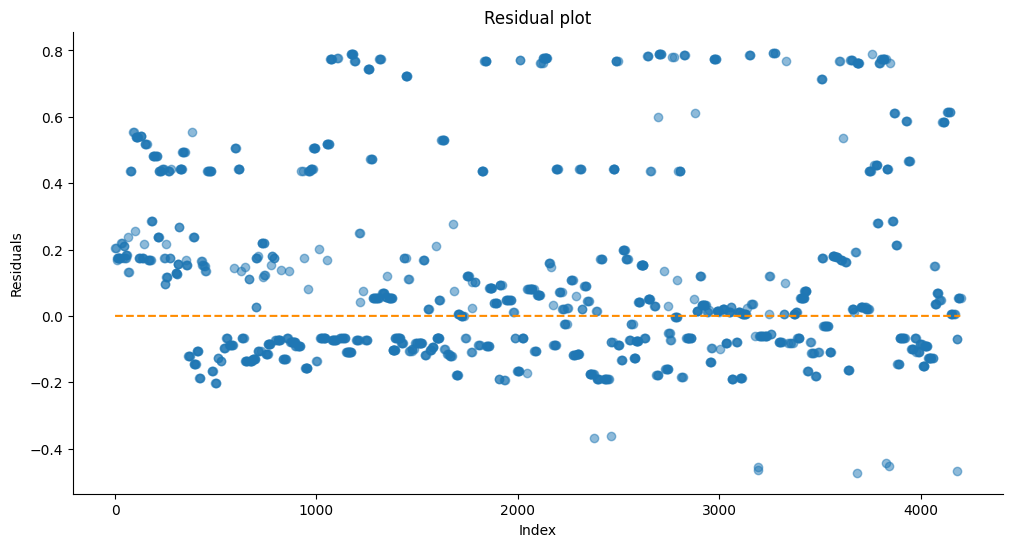

In [ ]:
homoscedasticity_assumption(s_model3, x3_test, y3_test)

**Interpretation:**We observe a fairly even spread of residuals both above and below the zero line across all indices, so there is some evidence of homoscedasticity

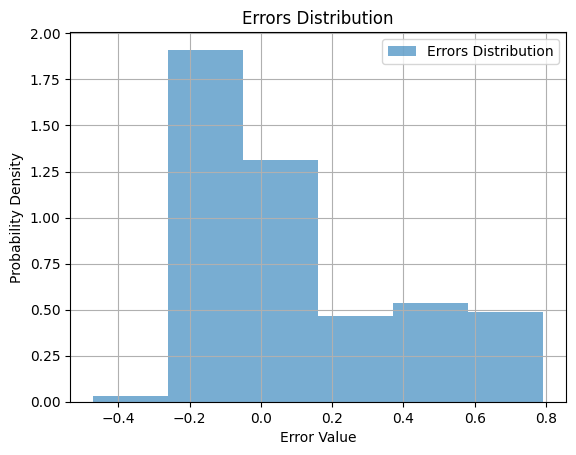

In [ ]:
df_results = calculate_residuals(s_model3, x3_test, y3_test)
plt.hist(df_results.Residuals, density=True, bins=6, alpha=0.6, label='Errors Distribution')  # Plot errors histogram
plt.xlabel('Error Value')
plt.ylabel('Probability Density')
plt.title('Errors Distribution')
plt.legend()
plt.grid(True)
plt.show()

0.9454219817192039


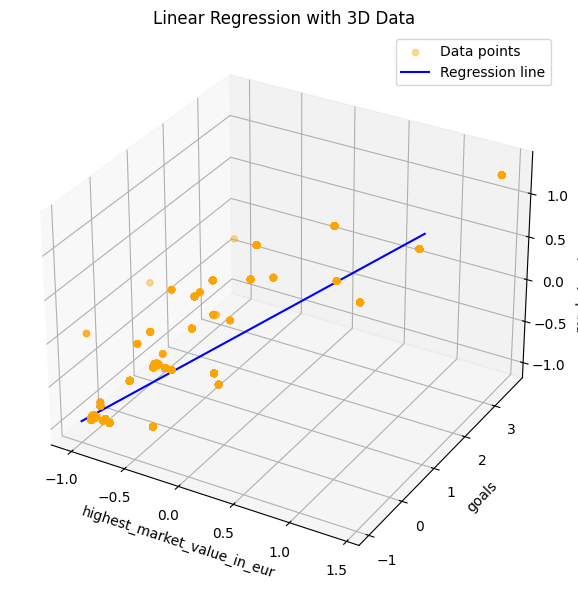

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_2 = df_multiple_scaled[['highest_market_value_in_eur', 'goals']].values.reshape(-1,2)
Y = df_multiple_scaled['market_value_in_eur']

x = X_2[:, 0]
y = X_2[:, 1]
z = Y

# Generate data for regression line
x1_line = np.arange(min(x), max(x), 0.1)
#x2_line = np.arange(min(y), max(y),0.1)
x2_line = np.array([s_model3.coef_[0] * val + (s_model3.intercept_ + s_model3.coef_[1] * np.mean(y)) for val in x1_line])
y_line = s_model3.coef_[0] * x1_line + s_model3.coef_[1] * x2_line + s_model3.intercept_

print(s_model3.coef_[0])
#print(x1_line) #global radiation
#print(x2_line)
# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(x, y, z, c='orange', marker='o', alpha=0.4, label='Data points')

# Plot regression line
ax.plot(x1_line, x2_line, y_line, c='b', label='Regression line')

# Set labels and title
ax.set_xlabel('highest_market_value_in_eur')
ax.set_ylabel('goals')
ax.set_zlabel('market_value_in_eur')
ax.set_title('Linear Regression with 3D Data')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation:**Linear Relationship: The regression line, shown in blue, represents the best-fit linear relationship between the independent variables and the dependent variable. It suggests that as the values of highest_market_value and assists increase, the value of the dependent variable also tends to increase.
Data Points: The orange dots represent the actual data points. The closer these points are to the regression line, the better the model's fit to the data.
Scatter: The data points are scattered around the regression line, indicating some variability in the relationship. This suggests that other factors not captured by the two independent variables might also influence the dependent variable.